# Predicting the edibility of mushrooms 
<img src="unknown-mushroom.jpg" width="200" align="left" style = "padding: 0px 10px 10px 0px;">  




Have you ever been walking around outside, seen a mushroom growing somewhere and wondered, "What would happen if I ate that?" Well, let's try and see if some features of mushrooms could be used to determine their edibility!* I compare the performance of several supervised machine learning models in their ability to predict whether a given mushroom is poisonous or not, using odor and habitat as predictors. 

**Discalimer: Do not eat mushrooms that you find growing outside*

First make sure you have the necessary dependencies:

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import SVC

Now we need our dataset. You can find it here: 

https://archive.ics.uci.edu/ml/datasets/Mushroom

Load it up: 

In [2]:
shrooms = pd.read_csv('agaricus-lepiota.data',header=0)

There are a number of interesting features, but I'm going to focus on odor and habitat as predictors of edibility. Let's see what these look like:

In [3]:
print(shrooms.edible.unique())
print(shrooms.odor.unique())
print(shrooms.habitat.unique())

['p' 'e']
['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
['u' 'g' 'm' 'd' 'p' 'w' 'l']


Okay so, the ```edible``` column contains values ```p``` for poisonous or ```e``` for edible. We can look at the link to the dataset above to decode the others.

| Odor               | Habitat     |
| :-----------        | :----------- |
| ```p``` : pungeant | ```u``` : urban       |
| ```a``` : almond   | ```g``` : grasses        |
| ```l``` : anise    | ```m``` : meadows       |
| ```n``` : none     | ```d``` : woods        |
| ```f``` : foul     | ```p``` : paths       |
| ```c``` : creosote | ```w``` : waste        |
| ```y``` : fishy    | ```l``` : leaves      |
| ```s``` : spicy    |         |
| ```m``` : musty    |  |

Let's get a sense of how each odor and habitat category break down into edible and poisonous. Create a count of each for each odor: 

In [4]:
odorf = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'f')).cumsum()).tolist())[-1]
odorp = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'p')).cumsum()).tolist())[-1]
odors = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 's')).cumsum()).tolist())[-1]
odorn = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'n')).cumsum()).tolist())[-1]
odora = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'a')).cumsum()).tolist())[-1]
odorl = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'l')).cumsum()).tolist())[-1]
odorc = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'c')).cumsum()).tolist())[-1]
odory = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'y')).cumsum()).tolist())[-1]
odorm = ((((shrooms['edible'] == 'p') & (shrooms['odor'] == 'm')).cumsum()).tolist())[-1]

odorf_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'f')).cumsum()).tolist())[-1]
odorp_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'p')).cumsum()).tolist())[-1]
odors_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 's')).cumsum()).tolist())[-1]
odorn_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'n')).cumsum()).tolist())[-1]
odora_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'a')).cumsum()).tolist())[-1]
odorl_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'l')).cumsum()).tolist())[-1]
odorc_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'c')).cumsum()).tolist())[-1]
odory_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'y')).cumsum()).tolist())[-1]
odorm_e = ((((shrooms['edible'] == 'e') & (shrooms['odor'] == 'm')).cumsum()).tolist())[-1]

poison_vals_odor = [odorf, odorp, odors, odorn, odora, odorl, odorc, odory, odorm]
edible_vals_odor = [odorf_e, odorp_e, odors_e, odorn_e, odora_e, odorl_e, odorc_e, odory_e, odorm_e]

print(poison_vals_odor)
print(edible_vals_odor)

[2160, 256, 576, 120, 0, 0, 192, 576, 36]
[0, 0, 0, 3408, 400, 400, 0, 0, 0]


Create a stacked barplot to visualize:

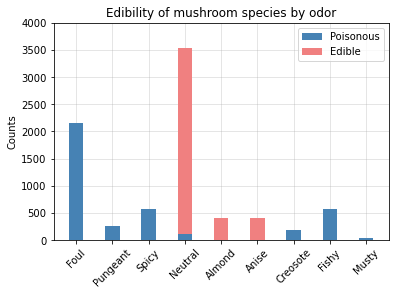

In [5]:
bar_labs_odor = ["Foul", "Pungeant", "Spicy", "Neutral", "Almond", "Anise", "Creosote", "Fishy", "Musty"]   #wanna count how many of each col are e or p to make the stack

fig, ax = plt.subplots()

ax.bar(bar_labs_odor, poison_vals_odor, width = 0.4, label='Poisonous', color = 'steelblue', zorder = 3)
ax.bar(bar_labs_odor, edible_vals_odor, width = 0.4, bottom=poison_vals_odor, label='Edible', color = 'lightcoral', zorder =3)

ax.set_ylabel('Counts')
ax.set_title('Edibility of mushroom species by odor')
ax.legend()

plt.xticks(rotation = 45)
plt.grid(True, alpha = .4, zorder = 0)
ax.set_ylim([0, 4000])

plt.show()

Here we can see that it's really quite cut and dry - mushrooms with a foul, pungeant, spicy, creosote (wood burning), fishy, or musty scent are categorically poisonous. Almond and anise-scented mushrooms are categorically edible. The only overlap occurs in neutral-scented mushrooms. I expect the models we create will be able to classify quite effectively, given the stark contrast. Let's try the same thing for habitats: 

[272, 0, 1268, 740, 592, 36, 1008]
[96, 192, 1880, 1408, 240, 256, 136]


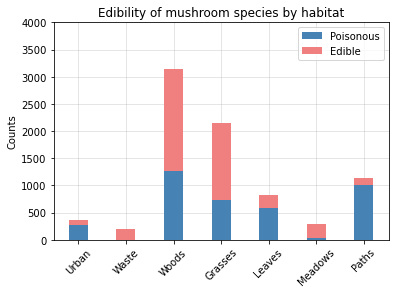

In [6]:
habu = ((((shrooms['edible'] == 'p') & (shrooms['habitat'] == 'u')).cumsum()).tolist())[-1]
habw = ((((shrooms['edible'] == 'p') & (shrooms['habitat'] == 'w')).cumsum()).tolist())[-1]
habd = ((((shrooms['edible'] == 'p') & (shrooms['habitat'] == 'd')).cumsum()).tolist())[-1]
habg = ((((shrooms['edible'] == 'p') & (shrooms['habitat'] == 'g')).cumsum()).tolist())[-1]
habl = ((((shrooms['edible'] == 'p') & (shrooms['habitat'] == 'l')).cumsum()).tolist())[-1]
habm = ((((shrooms['edible'] == 'p') & (shrooms['habitat'] == 'm')).cumsum()).tolist())[-1]
habp = ((((shrooms['edible'] == 'p') & (shrooms['habitat'] == 'p')).cumsum()).tolist())[-1]

habu_e = ((((shrooms['edible'] == 'e') & (shrooms['habitat'] == 'u')).cumsum()).tolist())[-1]
habw_e = ((((shrooms['edible'] == 'e') & (shrooms['habitat'] == 'w')).cumsum()).tolist())[-1]
habd_e = ((((shrooms['edible'] == 'e') & (shrooms['habitat'] == 'd')).cumsum()).tolist())[-1]
habg_e = ((((shrooms['edible'] == 'e') & (shrooms['habitat'] == 'g')).cumsum()).tolist())[-1]
habl_e = ((((shrooms['edible'] == 'e') & (shrooms['habitat'] == 'l')).cumsum()).tolist())[-1]
habm_e = ((((shrooms['edible'] == 'e') & (shrooms['habitat'] == 'm')).cumsum()).tolist())[-1]
habp_e = ((((shrooms['edible'] == 'e') & (shrooms['habitat'] == 'p')).cumsum()).tolist())[-1]

poison_vals_hab = [habu, habw, habd, habg, habl, habm, habp]
edible_vals_hab = [habu_e, habw_e, habd_e, habg_e, habl_e, habm_e, habp_e]


print(poison_vals_hab)
print(edible_vals_hab)


bar_labs_hab = ["Urban", "Waste", "Woods", "Grasses", "Leaves", "Meadows", "Paths"]   


fig, ax = plt.subplots()

ax.bar(bar_labs_hab, poison_vals_hab, width = 0.4, label='Poisonous', color = 'steelblue', zorder = 3)
ax.bar(bar_labs_hab, edible_vals_hab, width = 0.4, bottom=poison_vals_hab, label='Edible', color = 'lightcoral', zorder =3)

ax.set_ylabel('Counts')
ax.set_title('Edibility of mushroom species by habitat')
ax.legend()

plt.xticks(rotation = 45)
plt.grid(True, alpha = .4, zorder = 0)
ax.set_ylim([0, 4000])

plt.show()

A slightly less clear picture for habitat, but still some features that would be quite informative. Mushrooms growing in urban areas, paths, and among leaves are mostly poisonous. Mushrooms growing in meadows and on waste are mostly edible. That's counterintuitive that ones growing on actual garbage are not poisonous, but interesting! We can use these clear-cut features in our models. 

First, since the data are entirely categorical, we will use dummy/one-hot encoding to reshape into a form the models can make use of:

In [7]:
shrooms = shrooms[['edible', 'odor', 'habitat']]
shrooms_dummied = pd.get_dummies(shrooms)
list(shrooms_dummied.columns.values)

['edible_e',
 'edible_p',
 'odor_a',
 'odor_c',
 'odor_f',
 'odor_l',
 'odor_m',
 'odor_n',
 'odor_p',
 'odor_s',
 'odor_y',
 'habitat_d',
 'habitat_g',
 'habitat_l',
 'habitat_m',
 'habitat_p',
 'habitat_u',
 'habitat_w']

Next, let's split the data up so we can use it for training the models. We'll use `edible_p`, which as values of 1 or 0, as the classification label.  The others (except `edible_e`) will be used as the features:

In [8]:
labels = shrooms_dummied[['edible_p']]
data = shrooms_dummied[['odor_f', 'odor_p', 'odor_s', 'odor_n', 'odor_a', 'odor_l', 'habitat_u', 
                        'habitat_w', 'habitat_p','habitat_m', 'habitat_l','odor_c', 'odor_f']]


Split the data into training and test data:

In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(data,labels,test_size=0.2,random_state = 1)

Time to fit the models. First, let's see how a KNN model performs: 

In [10]:
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(train_data,np.ravel(train_labels))
print("KNN: " + str(classifier.score(test_data,test_labels)))

KNN: 0.9852307692307692


It performs quite well, which is not surprising, given the clear-cut nature of the data. Let's see how it does on habitat alone:

In [11]:
data = shrooms_dummied[['habitat_u', 'habitat_w', 'habitat_p','habitat_m', 'habitat_l']]
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2,random_state = 1)
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(train_data,np.ravel(train_labels))
print("KNN: " + str(classifier.score(test_data,test_labels)))

KNN: 0.6756923076923077


This degrades the performance of the model quite significantly, as might be expected. Maybe searching for a better value for *k* would improve its ability to make the classification. Let's try that out:

In [12]:
scores = []

for i in range(1,51):
    classifier = KNeighborsClassifier(n_neighbors = i)
    train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2,random_state = 1)
    classifier.fit(train_data,np.ravel(train_labels))
    scores.append(classifier.score(test_data,test_labels))
    
best_score = max(scores)
print("Best score uses k of " + str(scores.index(best_score) + 1) + " with score of " + str(best_score))

Best score uses k of 3 with score of 0.6756923076923077


It appears that increasing *k* doesn't offer much help. Let's go back and see how the model performs on odor by itself:

In [13]:
data = shrooms_dummied[['odor_f', 'odor_p', 'odor_s', 'odor_n', 'odor_a', 'odor_l', 'odor_c', 'odor_f']]
train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2,random_state = 1)
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(train_data,np.ravel(train_labels))
print("KNN: " + str(classifier.score(test_data,test_labels)))


KNN: 0.9803076923076923


Given only the different odors as features, the KNN model still performs exceptionally well - nearly as well as with odor and habitat combined. Would other types of models be so robust? With such decisive data, it seems likely, but let's try some out. Here I give the model score and confusion matrices for KNN, logistic regression, passive agressive, and SVM models using both the odor and habitat features:

In [14]:
data = shrooms_dummied[['odor_f', 'odor_p', 'odor_s', 'odor_n', 'odor_a', 'odor_l', 'habitat_u', 
                        'habitat_w', 'habitat_p','habitat_m', 'habitat_l','odor_c', 'odor_f']]

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size=0.2,random_state = 1)

#K Nearest Neighbors
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(train_data,np.ravel(train_labels))
print("KNN: " + str(classifier.score(test_data,test_labels)))
y_pred = classifier.predict(test_data)
print(confusion_matrix(test_labels, y_pred))

#Logistic Regression
logmod = LogisticRegression()
logmod.fit(train_data,np.ravel(train_labels))
print("\nLog: " + str(logmod.score(test_data, test_labels)))
y_pred_lin = logmod.predict(test_data)
print(confusion_matrix(test_labels, y_pred_lin))

#Passive agressive
passagg = PassiveAggressiveClassifier(C = 0.5)
passagg.fit(train_data,np.ravel(train_labels))
print("\nPass-agg: " + str(passagg.score(test_data, test_labels)))
y_pred_passagg = passagg.predict(test_data)
print(confusion_matrix(test_labels, y_pred_passagg))

#SVM
svm = SVC()
svm.fit(train_data,np.ravel(train_labels))
print("\nSVM: " + str(svm.score(test_data, test_labels)))
y_pred_svm = svm.predict(test_data)
print(confusion_matrix(test_labels, y_pred_svm))

KNN: 0.9852307692307692
[[820   0]
 [ 24 781]]

Log: 0.9803076923076923
[[820   0]
 [ 32 773]]

Pass-agg: 0.9852307692307692
[[820   0]
 [ 24 781]]

SVM: 0.9852307692307692
[[820   0]
 [ 24 781]]


They all perform similarly well, which again is not surprising given the characteristics of the data. Don't use these models to decide what you eat though, in case you encounter one of the false negatives! 


<img src="amanita-muscaria.jpg" width="200" align="left">